<a href="https://colab.research.google.com/github/SalehMehrabani/PyTorch-Deep-Learning/blob/main/NN6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification


## Data Preprocessing

In [2]:
from sklearn.datasets import make_circles

### Create 1000 circle sample

In [3]:
n_samples=1000
X, y= make_circles(n_samples, 
                   noise=0.03,
                   random_state=42)
len(X), len(y)

(1000, 1000)

### Creating DataFrame

In [4]:
import pandas as pd
circles= pd.DataFrame({"X1":X[:,0], 
                       "X2":X[:,1],
                       "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


### Visualizing Data

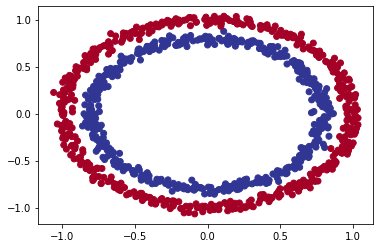

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

###Checking input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
import torch

### Turn Data into Tensors

In [8]:
X=torch.from_numpy(X).type(dtype=torch.float)
y=torch.from_numpy(y).type(dtype=torch.float)

###Split Data into training and test set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

## Building a model


In [10]:
import torch 
from torch import nn

In [11]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Create a model (Subclassing `nn.Module`)

In [12]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))
  
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### Setup loss function and optimizer


In [15]:
#Setup the loss function

# Without built-in sigmoid activation function
# loss_fn=nn.BCELoss()

# With built-in sigmoid activation function
loss_fn= nn.BCEWithLogitsLoss()
# Our model output are going to be raw LOGITs.

In [16]:
#Setup the Optimizer

optimizer= torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [17]:
#Calculate the accuracy
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc= (correct/len(y_pred))*100
  return acc

## Train Model

### Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [18]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1860],
        [ 0.1046],
        [ 0.0952],
        [ 0.2130],
        [-0.3877]], device='cuda:0', grad_fn=<SliceBackward0>)

In [19]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5464],
        [0.5261],
        [0.5238],
        [0.5531],
        [0.4043]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [20]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building Training and Test Loop

In [22]:
torch.manual_seed(42)

#Set the number of epoch
epochs=200

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Building training and evaluation loop:
for epoch in range(epochs):
  #Training
  model_0.train()

  ##Forward Pass
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits)) #turn logit -> pred probp -> pred label
  
  ##Claculate Loos/Accuracy
  loss = loss_fn(y_logits, y_train) ##nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  ##Optimizer zero grad
  optimizer.zero_grad()

  ##Loss backward - Backward Propagation
  loss.backward()

  ##Optimizer Step
  optimizer.step()

  #Testing
  model_0.eval()
  with torch.inference_mode():

    ##Forward pass
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    ##Claculate Test Loos/ Accuracy
    test_loss = loss_fn(test_logits, y_test) ##nn.BCEWithLogitsLoss expects raw logits as input
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  #Print th result
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70276, Accuracy: 49.88% | Test loss: 0.70217, Test acc: 46.50%
Epoch: 10 | Loss: 0.69992, Accuracy: 49.88% | Test loss: 0.69996, Test acc: 49.50%
Epoch: 20 | Loss: 0.69839, Accuracy: 49.62% | Test loss: 0.69869, Test acc: 51.00%
Epoch: 30 | Loss: 0.69737, Accuracy: 49.50% | Test loss: 0.69780, Test acc: 54.00%
Epoch: 40 | Loss: 0.69660, Accuracy: 49.62% | Test loss: 0.69709, Test acc: 54.50%
Epoch: 50 | Loss: 0.69599, Accuracy: 49.75% | Test loss: 0.69653, Test acc: 53.50%
Epoch: 60 | Loss: 0.69551, Accuracy: 49.75% | Test loss: 0.69608, Test acc: 53.00%
Epoch: 70 | Loss: 0.69511, Accuracy: 50.25% | Test loss: 0.69571, Test acc: 53.00%
Epoch: 80 | Loss: 0.69478, Accuracy: 50.00% | Test loss: 0.69542, Test acc: 53.50%
Epoch: 90 | Loss: 0.69450, Accuracy: 49.88% | Test loss: 0.69518, Test acc: 53.50%
Epoch: 100 | Loss: 0.69427, Accuracy: 49.88% | Test loss: 0.69499, Test acc: 54.00%
Epoch: 110 | Loss: 0.69408, Accuracy: 49.50% | Test loss: 0.69483, Test acc: 53.00%
Epo

### Make predictions and evaluate the model

In [31]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File already existed")
else:
  print("Downloading")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb")as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Downloading


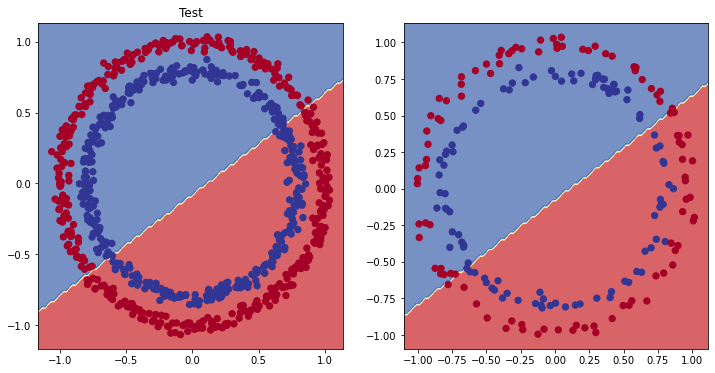

In [32]:
# Plot Decision boundry of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.title("Test")
plt.subplot(1,2,2)
plot_decision_boundary(model_0, X_test, y_test)

## Imporving model
* Add more layers - give the model more 
* chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function